In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
pd.options.plotting.backend = 'plotly'

import matplotlib.pyplot as plt
plt.style.use("bmh")

import numpy as np
import folium
import os

`County` and `State`

In [3]:
county = "Suffolk"
state = "Massachusetts"

In [4]:
csv_url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
df = pd.read_csv(csv_url)

In [5]:
def get_data_for_county(state, county):
    
    _df = df[(df.state == state) & (df.county == county)]
    return _df

In [6]:
suffolk_data = get_data_for_county(state, county)
suffolk_data["new_cases"] = suffolk_data.cases.diff()

In [7]:
suffolk_data["3day_rolling_mean"] = suffolk_data.new_cases.rolling(3, min_periods=3).mean()
suffolk_data["7day_rolling_mean"] = suffolk_data.new_cases.rolling(7, min_periods=7).mean()

In [8]:
#suffolk_data.set_index("date", inplace=True)
suffolk_data.head()

,date,county,state,fips,cases,deaths,new_cases,3day_rolling_mean,7day_rolling_mean
44,2020-02-01,Suffolk,Massachusetts,25025.0,1,0,NaN,NaN,NaN
52,2020-02-02,Suffolk,Massachusetts,25025.0,1,0,0.0,NaN,NaN
60,2020-02-03,Suffolk,Massachusetts,25025.0,1,0,0.0,NaN,NaN
68,2020-02-04,Suffolk,Massachusetts,25025.0,1,0,0.0,0.0,NaN
76,2020-02-05,Suffolk,Massachusetts,25025.0,1,0,0.0,0.0,NaN


__Interactive Plots__

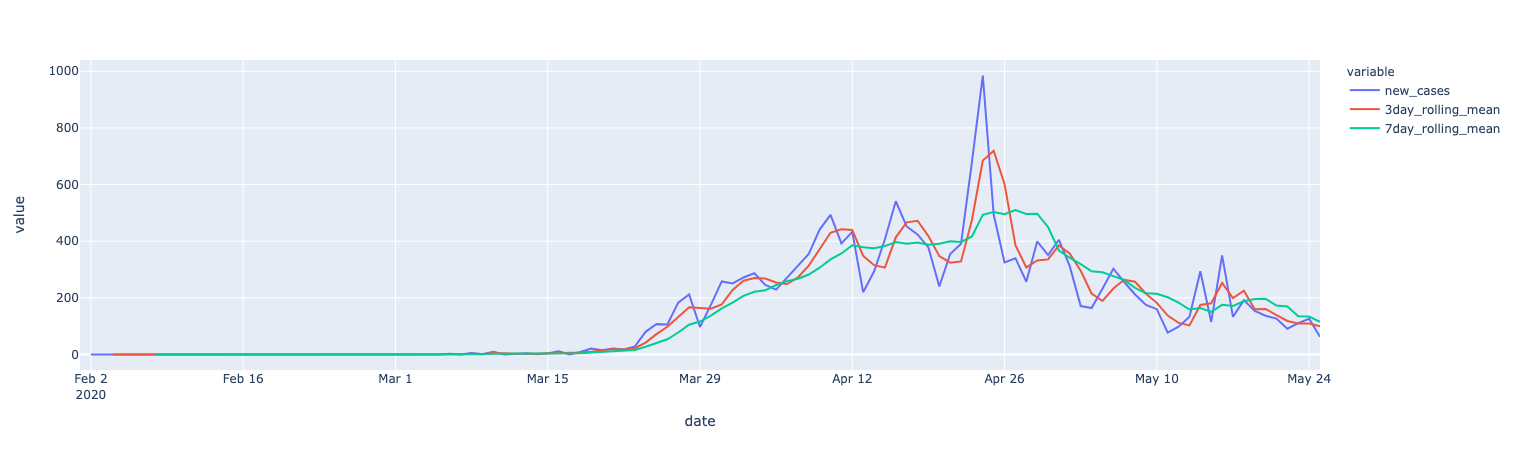

In [15]:
suffolk_data.plot(x="date", y=["new_cases"])
suffolk_data.plot(x="date", y=["new_cases", "3day_rolling_mean", "7day_rolling_mean"], kind="line")

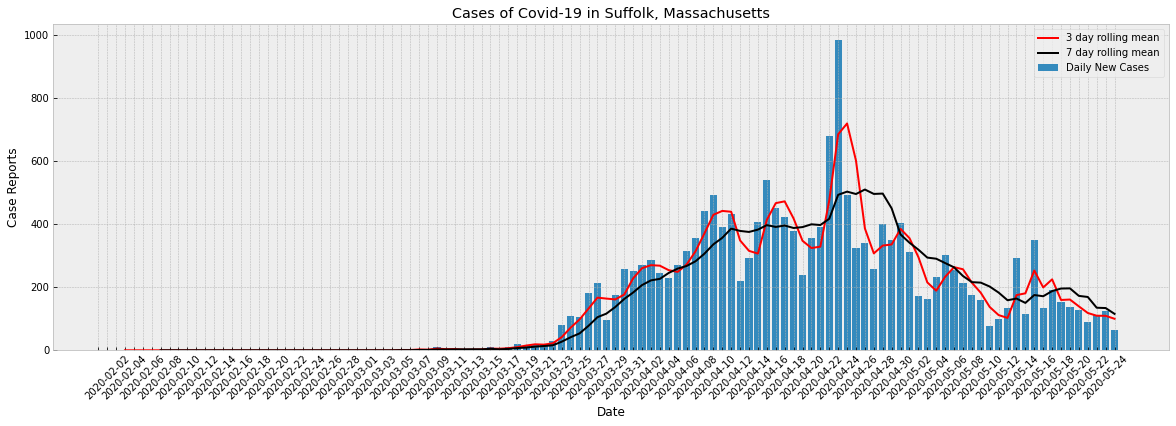

In [17]:
fig, ax = plt.subplots(figsize=(20,6))
ax.bar(suffolk_data.date, suffolk_data.new_cases, label="Daily New Cases")
ax.plot(suffolk_data.date, suffolk_data["3day_rolling_mean"], label="3 day rolling mean", color="Red")
ax.plot(suffolk_data.date, suffolk_data["7day_rolling_mean"], label="7 day rolling mean", color="Black")
ax.set_xlabel("Date")
ax.set_ylabel("Case Reports")
ax.set_title("Cases of Covid-19 in " + county + ", " + state)
ax.legend()
ax.set_xticklabels(labels=suffolk_data.date, rotation=45)
for label in ax.get_xticklabels()[::2]:
    label.set_visible(False)
plt.show()

__Create `Rate of Change` Marking Variables__

In [18]:
suffolk_data['lag1'] = suffolk_data['cases'].shift(1)
suffolk_data['ratio'] = suffolk_data.apply(lambda x: x['cases']/x['lag1'], axis=1)
suffolk_data['exp_ratio'] = suffolk_data["ratio"].apply(lambda x: np.exp(x))
suffolk_data['derivative'] = suffolk_data.apply(lambda x: 2 * ((x['cases'] - x['lag1'])/(x['cases'] + x['lag1'])), axis=1)

row_max_amplitude = suffolk_data.loc[suffolk_data['ratio'].idxmax()]
scale_factor = row_max_amplitude.cases / row_max_amplitude.derivative

suffolk_data['scaled_derivative'] = suffolk_data.apply(lambda x: scale_factor * x['derivative'], axis=1)

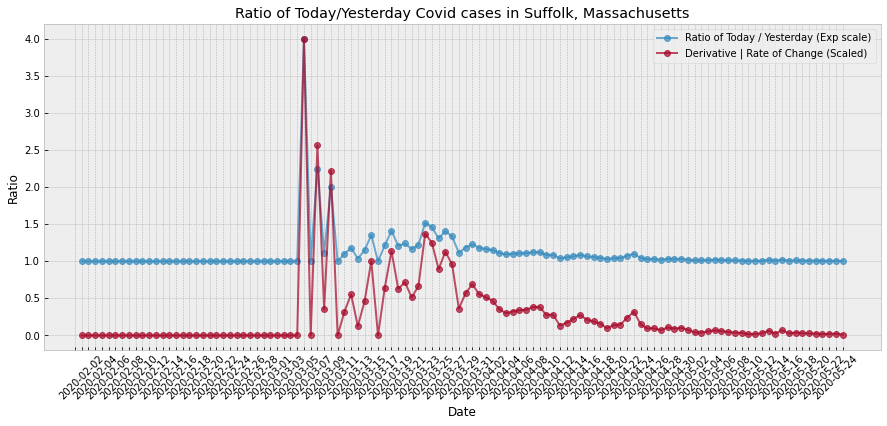

In [19]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(suffolk_data.date, suffolk_data.ratio, 'o-', label="Ratio of Today / Yesterday (Exp scale)", alpha=0.7)
ax.plot(suffolk_data.date, suffolk_data.scaled_derivative, 'o-', label="Derivative | Rate of Change (Scaled)", alpha=0.7)

ax.set_xlabel("Date")
ax.set_ylabel("Ratio")
ax.set_title("Ratio of Today/Yesterday Covid cases in " + county + ", " + state)
ax.legend()
ax.set_xticklabels(labels=suffolk_data.date, rotation=45)
for label in ax.get_xticklabels()[::2]:
    label.set_visible(False)
plt.show()